In [ ]:
!pip install datasets

In [39]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
from PIL import ImageOps, ImageEnhance, Image
import random
from IPython.display import display

In [ ]:
dataset = load_dataset('valhalla/emoji-dataset')

In [41]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})

# Convert image from PIL object to png, and store in different folder

In [42]:
def save_image(types, images_list):
    new_image_list = []
    for image_data in images_list:
        image = image_data['image']
        text = image_data['text']
        plt.imshow(image)
        plt.axis('off')
        new_image_list.append({'image': f'{types}/{text}.png', 'text': text})
        plt.savefig(f'{types}/{text}.png', bbox_inches='tight')
        plt.show()

        # reduce resolution
        image = Image.open(f'{types}/{text}.png')
        image = image.resize((64, 64))
        image.save(f'{types}/{text}.png')
        display(image)

    return new_image_list

before run this code, make sure you created train, validation, test folder

In [ ]:
selected_data = []
for data in dataset['train']:
    image = data['image']
    text = data['text']
    if 'face' in text or 'superhero' in text:
        selected_data.append(data)

random.shuffle(selected_data)
total_data = len(selected_data)
train_split = int(0.6 * total_data)
validation_split = int(0.2 * total_data) + train_split

train_data = selected_data[:train_split]
train_data = save_image("train", train_data)
validation_data = selected_data[train_split:validation_split]
validation_data = save_image("validation", validation_data)
test_data = selected_data[validation_split:]
test_data = save_image("test", test_data)

Now we have separate dataset into train_data, validation_data, test_data

In [44]:
print(train_data[0])

{'image': 'train/dog face.png', 'text': 'dog face'}


# Expand the dataset by applying data augmentation

In [45]:
def data_augmentation(image_path, round, label):
    # Load the image from the given path
    image = Image.open(image_path)

    operations = [
        lambda x: x.rotate(random.randint(-30, 30)),
        lambda x: ImageOps.mirror(x),
        lambda x: ImageOps.flip(x),
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.5, 1.5)),
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.5, 1.5)),
        lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.5, 1.5)),
    ]

    # Apply two random transformations
    ops = random.sample(operations, 2)
    for op in ops:
      image = op(image)

    first, ext = image_path.rsplit('.', 1)
    new_file_path = f"{first}_aug_{round}.{ext}"
    image.save(new_file_path)
    print(new_file_path)
    if "train" in first:
        train_data.append({'image': new_file_path, 'text': label})
    elif "validation" in first:
        validation_data.append({'image': new_file_path, 'text': label})
    elif "test" in first:
        test_data.append({'image': new_file_path, 'text': label})


In [ ]:
def expand_dataset(datas, rounds = 5):
    original_datas = datas[:]
    for round in range(rounds):
        for data in original_datas:
            image = data['image']
            text = data['text']
            data_augmentation(image, round, text)


In [ ]:
expand_dataset(train_data, 5)
expand_dataset(validation_data, 5)
expand_dataset(test_data, 5)

Now we have enough data in dataset

In [47]:
train_data = train_data[:600]
validation_data = validation_data[:200]
test_data = test_data[:200]

print(len(train_data))
print(train_data[0])

600
{'image': 'train/dog face.png', 'text': 'dog face'}


load all the data into datasets

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = Image.open(item['image'])
        text = item['text']
        if self.transform:
            image = self.transform(image)
        return image, text

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(validation_data, transform=train_transform)
test_dataset = CustomDataset(test_data, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Now batch size is set to 32, therefore each iteration will print out 32 image, and the length of train_loader will be 600/32 = 19

In [ ]:
for images, labels in train_loader:
    print(images) 
    print(labels) 
    break 
print(len(train_loader))
print(len(images), len(images[0]), len(images[0][0]))

# Problem 1: Convolution based autoencoder

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [95]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super(AutoEncoderCNN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # print(f"Input: {x.size()}")
        x = self.encoder(x)
        # print(f"Encoded: {x.size()}")
        x = self.decoder(x)
        # print(f"Output: {x.size()}")
        return x


summary of the model

In [96]:
from torchsummary import summary

In [ ]:
model = AutoEncoderCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(summary(model, (4, 224, 224)))

Epoch 1, Train Loss: 0.1152, Validation Loss: 0.0819
Epoch 2, Train Loss: 0.0742, Validation Loss: 0.0667
Epoch 3, Train Loss: 0.0625, Validation Loss: 0.0583
Epoch 4, Train Loss: 0.0516, Validation Loss: 0.0452
Epoch 5, Train Loss: 0.0389, Validation Loss: 0.0350
Epoch 6, Train Loss: 0.0325, Validation Loss: 0.0297
Epoch 7, Train Loss: 0.0275, Validation Loss: 0.0273
Epoch 8, Train Loss: 0.0250, Validation Loss: 0.0247
Epoch 9, Train Loss: 0.0233, Validation Loss: 0.0238
Epoch 10, Train Loss: 0.0225, Validation Loss: 0.0238
Epoch 11, Train Loss: 0.0220, Validation Loss: 0.0228
Epoch 12, Train Loss: 0.0209, Validation Loss: 0.0218
Epoch 13, Train Loss: 0.0198, Validation Loss: 0.0215
Epoch 14, Train Loss: 0.0197, Validation Loss: 0.0219
Epoch 15, Train Loss: 0.0196, Validation Loss: 0.0209
Epoch 16, Train Loss: 0.0184, Validation Loss: 0.0205
Epoch 17, Train Loss: 0.0182, Validation Loss: 0.0207
Epoch 18, Train Loss: 0.0177, Validation Loss: 0.0199
Epoch 19, Train Loss: 0.0172, Validat

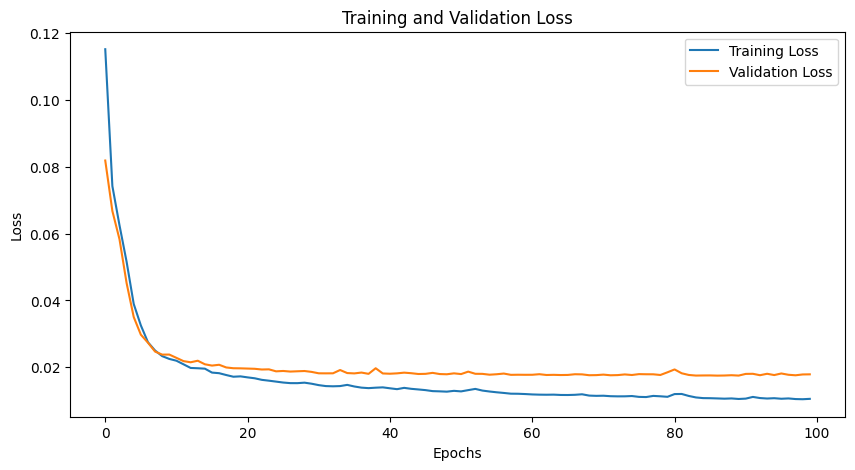

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim



train_losses = []
val_losses = []

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, _ = data
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'autoencoder_model.pth')

Now test on testing dataset

In [99]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

test_loss = test_loss / len(test_loader.dataset)

print(f"Average Test Loss: {test_loss:.4f}")

Average Test Loss: 0.0175


# Problem 2

We set batch size to 20, since 20 can be divided by both training size (600) and validation size (200)

In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

key_word = {'bear', 'cat', 'clock', 'clown', 'cow', 'horse', 'lion', 'panda', 'pig', 'robot', 'horn', 'unicorn', 'wind', 'wolf', 'zebra', 'moon', 'mouse', 'rabbit', 'dog', 'dragon', 'fox', 'frog', 'hamster', 'monkey', 'sun', 'tiger'}


class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = Image.open(item['image'])
        # Check if any word in item['text'] is in key_word
        label = 1 if any(word in key_word for word in item['text'].split()) else 0
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(validation_data, transform=train_transform)
test_dataset = CustomDataset(test_data, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [ ]:
for images, labels in train_loader:
    print(images) 
    print(labels) 
    break 
print(len(train_loader))
print(len(images), len(images[0]), len(images[0][0]))

In [76]:
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ClassifierCNN, self).__init__()
        # Encoder (used as feature extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # decode
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Sigmoid(),
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 4 * 4, num_classes)  # Adjust the size according to your input image size

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x, y

Epoch 1, Train Loss: 0.3724, Validation Loss: 0.2574
Epoch 2, Train Loss: 0.2797, Validation Loss: 0.2332
Epoch 3, Train Loss: 0.1949, Validation Loss: 0.2584
Epoch 4, Train Loss: 0.1548, Validation Loss: 0.2311
Epoch 5, Train Loss: 0.1158, Validation Loss: 0.1861
Epoch 6, Train Loss: 0.0887, Validation Loss: 0.1635
Epoch 7, Train Loss: 0.0749, Validation Loss: 0.2226
Epoch 8, Train Loss: 0.0830, Validation Loss: 0.2481
Epoch 9, Train Loss: 0.0750, Validation Loss: 0.2310
Epoch 10, Train Loss: 0.0561, Validation Loss: 0.3167
Epoch 11, Train Loss: 0.0417, Validation Loss: 0.2610
Epoch 12, Train Loss: 0.0538, Validation Loss: 0.2086
Epoch 13, Train Loss: 0.0376, Validation Loss: 0.3317
Epoch 14, Train Loss: 0.0327, Validation Loss: 0.1497
Epoch 15, Train Loss: 0.0280, Validation Loss: 0.3628
Epoch 16, Train Loss: 0.0233, Validation Loss: 0.2727
Epoch 17, Train Loss: 0.0204, Validation Loss: 0.2577
Epoch 18, Train Loss: 0.0192, Validation Loss: 0.2561
Epoch 19, Train Loss: 0.0183, Validat

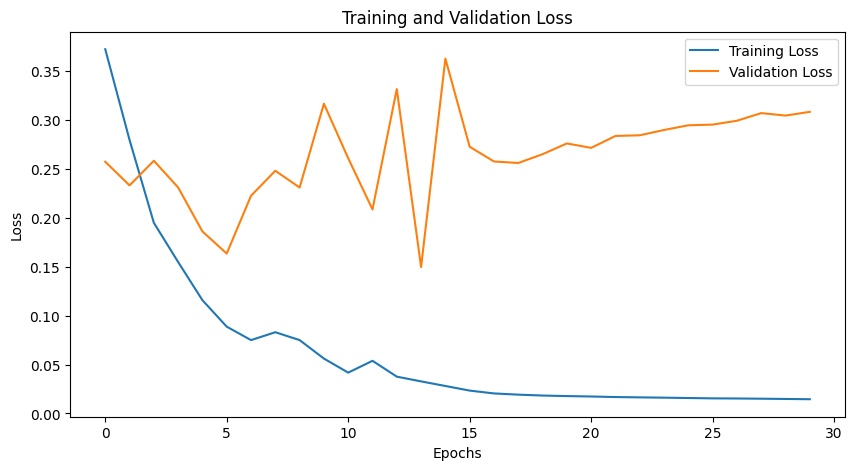

In [79]:
train_losses = []
val_losses = []

num_classes = 2
model = ClassifierCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

lambda_value = 0.5

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        class_scores, recon = model(images)

        recon_loss = reconstruction_criterion(recon, images)
        class_loss = classification_criterion(class_scores, labels)

        total_loss = recon_loss + lambda_value * class_loss

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item() * images.size(0)

    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            class_scores, recon = model(images)

            recon_loss = reconstruction_criterion(recon, images)
            class_loss = classification_criterion(class_scores, labels)

            total_loss = recon_loss + lambda_value * class_loss

            val_loss += total_loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'classification_model.pth')

In [80]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        class_scores, recon = model(images)
        recon_loss = reconstruction_criterion(recon, images)
        class_loss = classification_criterion(class_scores, labels)

        total_loss = recon_loss + lambda_value * class_loss

        test_loss += total_loss.item() * images.size(0)

test_loss = test_loss / len(test_loader.dataset)

print(f"Average Test Loss: {test_loss:.4f}")

Average Test Loss: 3.9382


# Problem 3

pass specific image to Dataloader

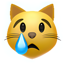

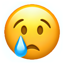

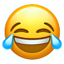

In [105]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

image_path_1 = '/content/train/crying cat face.png'
image_1 = Image.open(image_path_1)
display(image_1)

image_path_2 = '/content/train/crying face.png'
image_2 = Image.open(image_path_2)
display(image_2)

image_path_3 = '/content/train/face with tears of joy.png'
image_3 = Image.open(image_path_3)
display(image_3)

image_1 = transform(image_1)
image_2 = transform(image_2)
image_3 = transform(image_3)



# Add a batch dimension by using `unsqueeze`
image_1 = image_1.unsqueeze(0).to(device)
image_2 = image_2.unsqueeze(0).to(device)
image_3 = image_3.unsqueeze(0).to(device)



Since we already trained autoencoder, we will load the model path

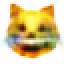

In [113]:
import numpy as np

model = AutoEncoderCNN().to(device)

model.load_state_dict(torch.load('/content/autoencoder_model.pth'))
model.eval()

with torch.no_grad():
    image_1_encode = model.encoder(image_1.to(device))
    image_2_encode = model.encoder(image_2.to(device))
    image_3_encode = model.encoder(image_3.to(device))

    modified_vector = image_1_encode - image_2_encode + image_3_encode

    # print(image_1_encode)
    # print(image_2_encode)
    # print(image_3_encode)

    # print(image_1_encode - image_2_encode)
    # print(modified_vector)

    decoded_image = model.decoder(modified_vector)

generated_image = decoded_image.squeeze(0)  # Remove batch dimension if necessary
generated_image = generated_image.permute(1, 2, 0)  # Rearrange dimensions to [H, W, C]
generated_image = generated_image.cpu().numpy()  
generated_image = (generated_image * 255).astype(np.uint8)  # Assuming the original normalization was to [0,1]
generated_image_pil = Image.fromarray(generated_image)
display(generated_image_pil)

